# Extra: Basics of Bayesian Inference

**WORK IN PROGRESS**

In [34]:
# Import required packages.
# - Plot figures inline with text in this notebook.
%matplotlib inline
# - Higher DPI figures.
%config InlineBackend.figure_format='retina'
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import Source.BerghTijdemanWhitmoreModels as tt_m  # Analytical models.
import Source.BayesianInferenceFunctions as bi_f  # Bayesian inference.
from Source.ProcessingFunctions import frequency_response  # Complex TF to amplitude and phase of TF.
from Source.PlottingFunctions import plot_transfer_function_df, freq_resp_style  # Plotting of TFs.

In [35]:
LRV_SOLUTION = (2E-3, 0.25E-3, 20E-9)
GAMMA, PR, C0, NU = 1.4, 0.7, 340.26, 1.46E-5  # Conditions used in model.
# Minimum frequency, maximum frequency, number of samples between min and max.
F_MIN, F_MAX, N_F_SAMPLES = 1E2, 2E4, 1001

# Frequency array in Hz.
f_arr = np.logspace(np.log10(F_MIN), np.log10(F_MAX),N_F_SAMPLES)
w_arr = 2*np.pi*f_arr  # Frequency array in rad/s.
# Normalised geometrical parameters, but with the real valued norm of the shear wave number (constant).
norm_solution = tt_m.dim_to_norm(*LRV_SOLUTION, c0=C0, nu=NU, alpha_complex=False)

In [36]:
def model(alpha_i, w=w_arr):
    el_pin = tt_m.Element(k_l_pre=norm_solution[0], alpha_pre=alpha_i[0]*1j**1.5, vv_vt=alpha_i[1], gamma=GAMMA, pr=PR)
    pr_pin = el_pin(w=w)
    return frequency_response(pr_pin)

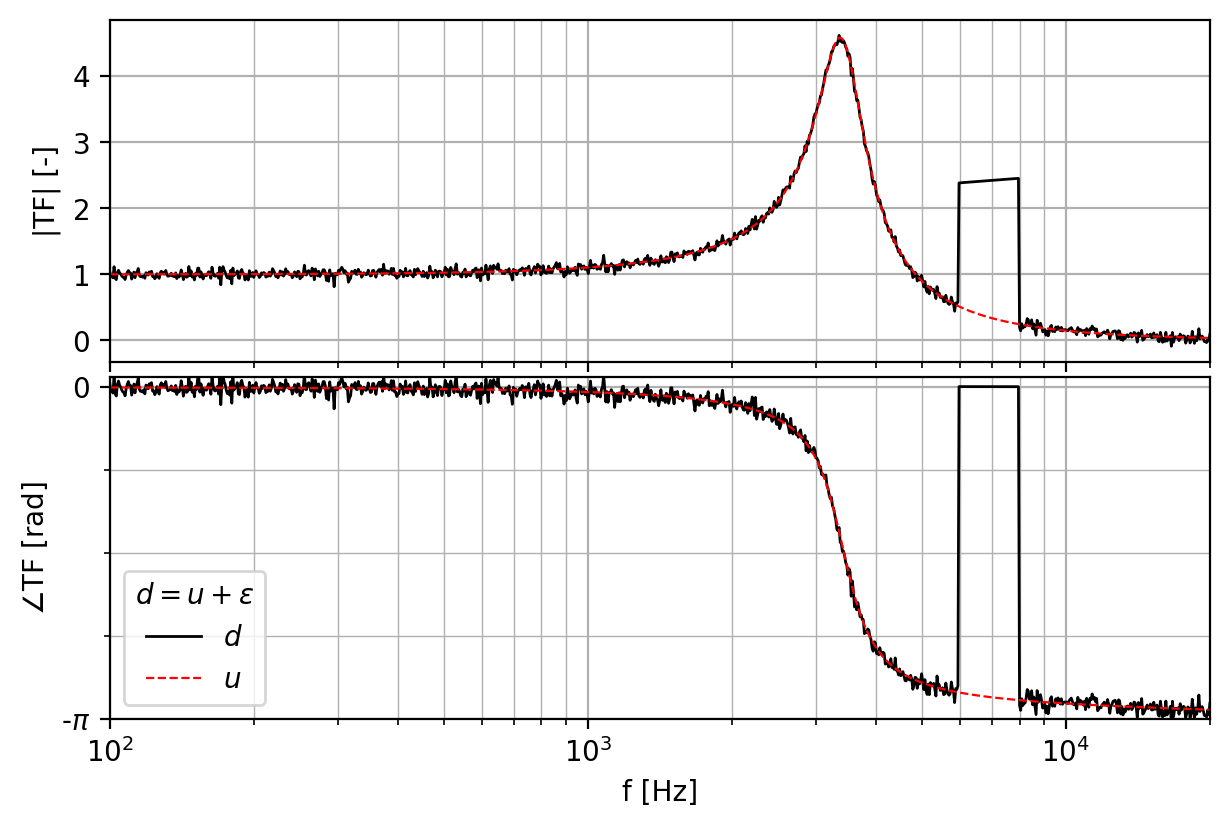

In [37]:
NOISE_SD = 0.05
noise = stats.norm(loc=0, scale=NOISE_SD).rvs(N_F_SAMPLES)

mask_sp_res, f_sp_res = bi_f.mask_f_data(frequency=f_arr, f_mask_arr=[[0.3*(F_MAX-F_MIN), 0.4*(F_MAX-F_MIN)]])

amp_d, phase_d = model(alpha_i=norm_solution[1:], w=w_arr)
amp_d_true, phase_d_true = np.copy(amp_d), np.copy(phase_d)
amp_d, phase_d = amp_d + noise, phase_d + noise
amp_d[mask_sp_res], phase_d[mask_sp_res] = f_sp_res**0.1, f_sp_res**-0.6

fig, ax = plt.subplots(2, 1, sharex='col', figsize=(6, 4))
freq_resp_style(ax=ax, phase_lim=(-np.pi, 0.1), pi_phase_sub=0.25)
ax[1].set_xlim(F_MIN, F_MAX)
ax[0].plot(f_arr, amp_d, color='k', linestyle='-', linewidth=1, alpha=1, label=r'$d$')
ax[1].plot(f_arr, phase_d, color='k', linestyle='-', linewidth=1, alpha=1, label=r'$d$')
ax[0].plot(f_arr, amp_d_true, color='r', linestyle='--', linewidth=0.8, alpha=1, label=r'$u$')
ax[1].plot(f_arr, phase_d_true, color='r', linestyle='--', linewidth=0.8, alpha=1, label=r'$u$')
ax[1].legend(loc='lower left', title=r'$d=u+\varepsilon$');
fig.tight_layout(pad=0.1)

In [38]:
def likelihood_log_pdf(u, d, sigma_d):
    """
    Likelihood of model state with data, given measurement variance.

    :param u: Model state vector.
    :param d: Measurement vector.
    :param sigma_d: Measurement variance.

    :return: Value of log likelihood PDF.
    """
    d_hu = d - u
    log_rho = float(np.sum(stats.norm.logpdf(x=d_hu, scale=sigma_d)))
    return log_rho

In [39]:
ALPHA_VV_VT_PRIOR_MEAN = (0.1*norm_solution[1], 0.1*norm_solution[1])
ALPHA_VV_VT_PRIOR_SD = (0.1, 0.1)
ALPHA_MIN, ALPHA_MAX, ALPHA_N = 0.5*norm_solution[1], 2*norm_solution[1], 11
VV_VT_MIN, VV_VT_MAX, VV_VT_N = 0.5*norm_solution[2], 2*norm_solution[2], 11
SIGMA_D = 0.1

prior_obj = stats.norm(loc=ALPHA_VV_VT_PRIOR_MEAN, scale=ALPHA_VV_VT_PRIOR_SD)

alpha_samples = np.linspace(ALPHA_MIN, ALPHA_MAX, ALPHA_N)
vv_vt_samples = np.linspace(VV_VT_MIN, VV_VT_MAX, VV_VT_N)
xx_samples, yy_samples = np.meshgrid(alpha_samples, vv_vt_samples)

likelihood_pdf_arr = np.zeros(xx_samples.shape)
prior_pdf_arr = np.zeros(xx_samples.shape)

for i in range(xx_samples.shape[0]):
    for j in range(xx_samples.shape[1]):
        amp_u, phase_u = model(alpha_i=(xx_samples[i, j], yy_samples[i, j]), w=w_arr)
        likelihood_pdf_arr[i, j] = likelihood_log_pdf(u=amp_u, d=amp_d, sigma_d=SIGMA_D) + \
                                   likelihood_log_pdf(u=phase_u, d=phase_d, sigma_d=SIGMA_D)
        prior_pdf_arr[i, j] = float(np.sum(prior_obj.logpdf(x=(xx_samples[i, j], yy_samples[i, j]))))

posterior_pdf_arr = likelihood_pdf_arr + prior_pdf_arr

C:\Users\Olivier\AppData\Local\Temp\ipykernel_21776\2363100274.py:2: UserWarning: The following kwargs were not used by contour: 'label'
  ax_pdf.contour(xx_samples, yy_samples, prior_pdf_arr, colors='b', label='prior')
C:\Users\Olivier\AppData\Local\Temp\ipykernel_21776\2363100274.py:3: UserWarning: The following kwargs were not used by contour: 'label'
  ax_pdf.contour(xx_samples, yy_samples, likelihood_pdf_arr, colors='r', label='likelihood')
C:\Users\Olivier\AppData\Local\Temp\ipykernel_21776\2363100274.py:4: UserWarning: The following kwargs were not used by contour: 'label'
  ax_pdf.contour(xx_samples, yy_samples, posterior_pdf_arr, colors='k', label='posterior')
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


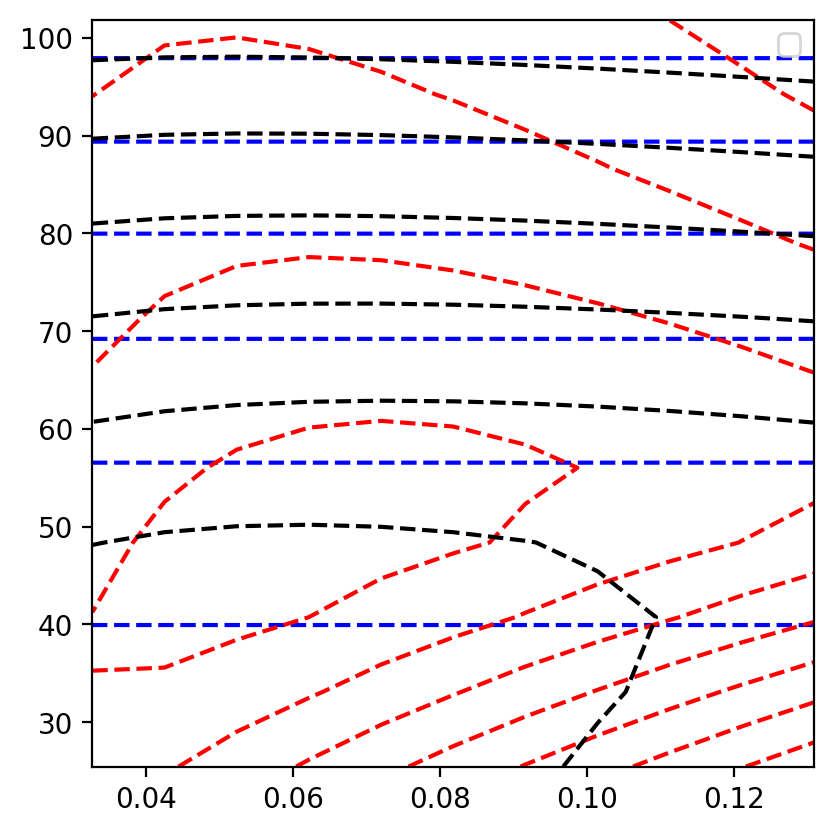

In [40]:
fig_pdf, ax_pdf = plt.subplots(1, 1, figsize=(4, 4))
ax_pdf.contour(xx_samples, yy_samples, prior_pdf_arr, colors='b', label='prior')
ax_pdf.contour(xx_samples, yy_samples, likelihood_pdf_arr, colors='r', label='likelihood')
ax_pdf.contour(xx_samples, yy_samples, posterior_pdf_arr, colors='k', label='posterior')
# ax_pdf.set
ax_pdf.legend()
fig_pdf.tight_layout(pad=0.1)